In [35]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [36]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())
    print(img_batch[0])

(32, 256, 256, 3)
[0 0 0 0 0 1 0 1 2 1 1 1 1 0 1 1 2 1 0 1 0 0 1 1 1 0 2 1 2 1 1 2]
tf.Tensor(
[[[175. 177. 189.]
  [177. 179. 191.]
  [177. 179. 191.]
  ...
  [188. 191. 200.]
  [188. 191. 200.]
  [189. 192. 201.]]

 [[175. 177. 189.]
  [177. 179. 191.]
  [179. 181. 193.]
  ...
  [202. 205. 214.]
  [201. 204. 213.]
  [195. 198. 207.]]

 [[170. 172. 184.]
  [173. 175. 187.]
  [174. 176. 188.]
  ...
  [204. 207. 216.]
  [202. 205. 214.]
  [195. 198. 207.]]

 ...

 [[130. 126. 141.]
  [137. 133. 148.]
  [139. 135. 149.]
  ...
  [152. 150. 163.]
  [150. 148. 161.]
  [154. 152. 165.]]

 [[140. 136. 151.]
  [135. 131. 146.]
  [131. 127. 141.]
  ...
  [156. 154. 167.]
  [154. 152. 165.]
  [156. 154. 167.]]

 [[137. 133. 148.]
  [125. 121. 136.]
  [119. 115. 129.]
  ...
  [144. 142. 155.]
  [138. 136. 149.]
  [137. 135. 148.]]], shape=(256, 256, 3), dtype=float32)


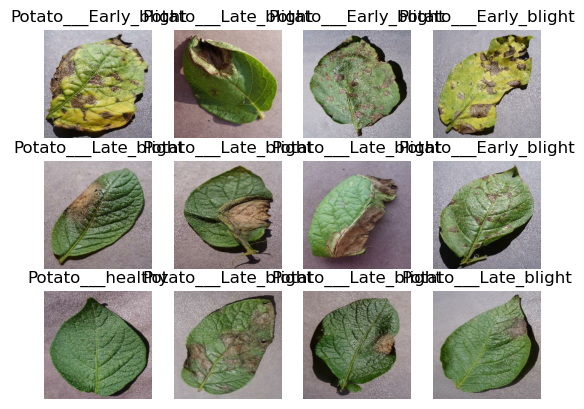

In [8]:
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
#  in this we divide the dataset into training, validation and test
#  in the ratio of 80:10:10

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(ds_size*train_split)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [22]:
data_augmentaion = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [23]:
CHANNELS = 3 
BATCH_SIZE = 32

model = models.Sequential([
#     layers.InputLayer(input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale, 
    data_augmentaion, 
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), 
    layers.Dense(3, activation = 'softmax')
])

model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [26]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1, 
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.5805 - loss: 0.9123 - val_accuracy: 0.8177 - val_loss: 0.6129
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8421 - loss: 0.4850 - val_accuracy: 0.7188 - val_loss: 0.6629
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8558 - loss: 0.4377 - val_accuracy: 0.7812 - val_loss: 0.6012
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8412 - loss: 0.3953 - val_accuracy: 0.9010 - val_loss: 0.3302
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8886 - loss: 0.2718 - val_accuracy: 0.9427 - val_loss: 0.2345
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9174 - loss: 0.2140 - val_accuracy: 0.8750 - val_loss: 0.2835
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9460 - loss: 0.1594 - val_accuracy: 0.9583 - val_loss: 0.1502
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9268 - loss: 0.1983 - val_accuracy: 0.9115 - val_lo

In [27]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - accuracy: 0.9574 - loss: 0.1075


In [28]:
score

[0.13424666225910187, 0.94921875]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'training and validation loss')

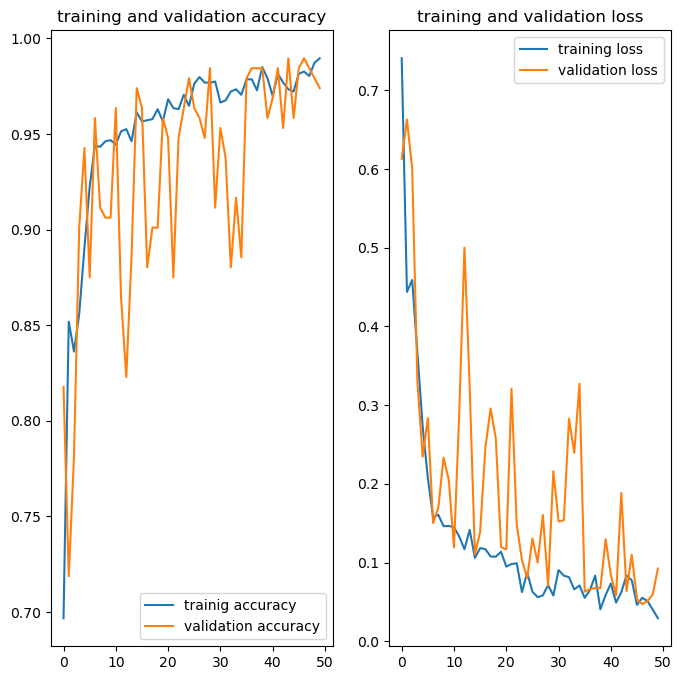

In [40]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'trainig accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.title('training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'training loss')
plt.plot(range(EPOCHS), val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('training and validation loss')

first img to predict
actual label : Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
predicted label : Potato___Late_blight


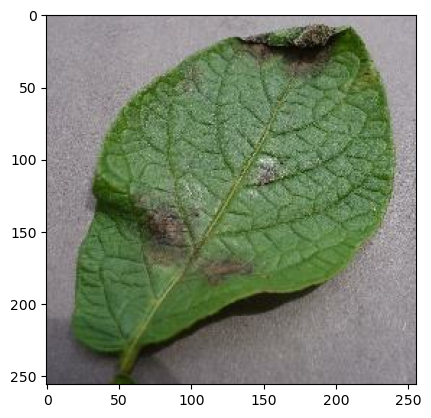

In [42]:
for image_batch, labels_batch in test_ds.take(1):
    first_img = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first img to predict')
    plt.imshow(first_img)
    print('actual label :', class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('predicted label :', class_names[np.argmax(batch_prediction[0])])

In [52]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img[i])
    img_array = tf.expand_dims(img_array, 0)  #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 *(np.max(predictions[0])), 2)
    return predicted_class, confidence

InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
<stack traces unavailable>
Depth of input must be a multiple of depth of filter: 1 vs 3

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "D:\Anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
File "D:\Anaconda\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
File "D:\Anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
File "D:\Anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
File "D:\Anaconda\Lib\asyncio\base_events.py", line 607, in run_forever
File "D:\Anaconda\Lib\asyncio\base_events.py", line 1922, in _run_once
File "D:\Anaconda\Lib\asyncio\events.py", line 80, in _run
File "D:\Anaconda\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
File "D:\Anaconda\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
File "D:\Anaconda\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
File "D:\Anaconda\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
File "D:\Anaconda\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
File "D:\Anaconda\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
File "D:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
File "D:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
File "D:\Anaconda\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
File "D:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
File "D:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
File "D:\Anaconda\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_24396\3067061734.py", line 7, in <module>
File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_24396\1939797329.py", line 5, in predict
File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "D:\Anaconda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 519, in predict
File "D:\Anaconda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 217, in one_step_on_data_distributed
File "D:\Anaconda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 206, in one_step_on_data
File "D:\Anaconda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 98, in predict_step
File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "D:\Anaconda\Lib\site-packages\keras\src\layers\layer.py", line 826, in __call__
File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "D:\Anaconda\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__
File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler
File "D:\Anaconda\Lib\site-packages\keras\src\models\sequential.py", line 206, in call
File "D:\Anaconda\Lib\site-packages\keras\src\models\functional.py", line 199, in call
File "D:\Anaconda\Lib\site-packages\keras\src\ops\function.py", line 151, in _run_through_graph
File "D:\Anaconda\Lib\site-packages\keras\src\models\functional.py", line 583, in call
File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "D:\Anaconda\Lib\site-packages\keras\src\layers\layer.py", line 826, in __call__
File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
File "D:\Anaconda\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__
File "D:\Anaconda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler
File "D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 224, in call
File "D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 214, in convolution_op
File "D:\Anaconda\Lib\site-packages\keras\src\ops\nn.py", line 909, in conv
File "D:\Anaconda\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 279, in conv
File "D:\Anaconda\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 269, in _conv_xla
File "D:\Anaconda\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 256, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference__conv_xla_44002[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[sequential_2_1/conv2d_1/StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_44060]

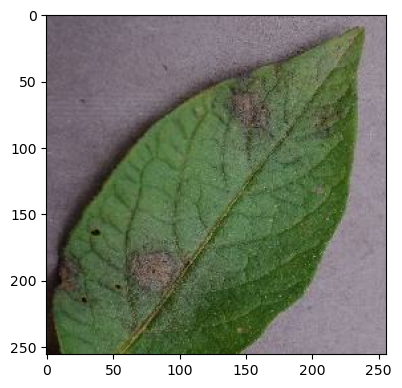

In [54]:
plt.figure(figsize=(15,15))
for img, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, img[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.")
        plt.axis("off")